## 모바일 퍼즐 게임 A/B 테스트 결과 분석 

이 AB 테스트는 모바일 퍼즐 게임 Cookie Cats의 유저가 게이트에 도달하는 시점을 30 레벨에서 40 레벨로 옮겼을 때, 유저들의 접속(retention)에 어떤 변화가 있는지를 추적한 데이터입니다. 30 라운드 이상 플레이한 유저들을 대상으로 데이터를 분석한 결과, 유저들의 접속과 게이트 레벨의 이동은 관련이 없다는 결론을 내릴 수 있었습니다. 다만, 유저들의 지속적인 접속을 위해서는 게이트의 위치가 아닌 초기 이탈을 줄이는 방안을 고안할 필요가 있어 보입니다.


In [1]:
import pandas as pd

df = pd.read_csv("./CookieCats/cookie_cats.csv", encoding="utf-8")

In [2]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


## 1. EDA와 전처리

In [3]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [4]:
# 중앙값이 16라운드까지밖에 진행을 안 했네 -> 30라운드 이상 진행한 플레이어는 몇명이지? -> 총 33269명
df[df["sum_gamerounds"] >= 30]

,userid,version,sum_gamerounds,retention_1,retention_7
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
8,1574,gate_40,108,True,True
...,...,...,...,...,...
90177,9998376,gate_40,53,False,False
90178,9998555,gate_40,32,False,False
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False


In [5]:
# 33269명도 충분한 숫자니까 그냥 나머지는 제외시키자.
df = df[df["sum_gamerounds"] >= 30]
df.reset_index()

,index,userid,version,sum_gamerounds,retention_1,retention_7
0,1,337,gate_30,38,True,False
1,2,377,gate_40,165,True,False
2,4,488,gate_40,179,True,True
3,5,540,gate_40,187,True,True
4,8,1574,gate_40,108,True,True
...,...,...,...,...,...,...
33264,90177,9998376,gate_40,53,False,False
33265,90178,9998555,gate_40,32,False,False
33266,90184,9999441,gate_40,97,True,False
33267,90185,9999479,gate_40,30,False,False


<Axes: >

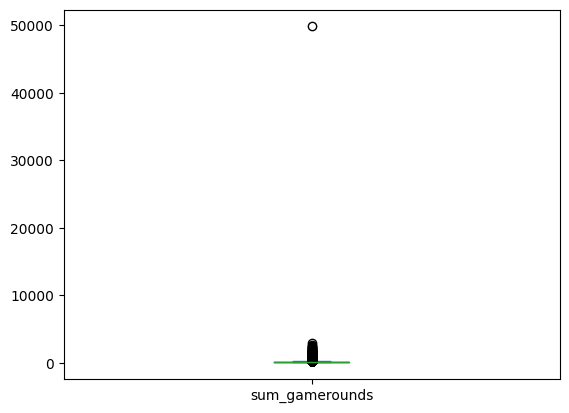

In [6]:
# sum_gamerounds의 박스 플랏 -> 눈에 띄는 outlier가 있군!
import matplotlib as plt

df["sum_gamerounds"].plot(
    kind="box"
)

In [7]:
# 4만회나 플레이했다고? 상위 10명을 살펴보자 -> 역시 4만회 저 유저만 이상하다
df.sort_values(
    by=["sum_gamerounds"],
    ascending = False
).iloc[:10]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
46344,5133952,gate_30,2251,True,True
87007,9640085,gate_30,2156,True,True
36933,4090246,gate_40,2124,True,True
88328,9791599,gate_40,2063,True,True
6536,725080,gate_40,2015,True,True


In [8]:
# 아웃라이어 제거
df = df[df["sum_gamerounds"] < 40000]

In [9]:
# 통계값을 보니 더이상의 아웃라이어 제거는 안 해도 될 것 같다
df.describe()

,userid,sum_gamerounds
count,3.326800e+04,33268.000000
mean,5.002768e+06,123.278075
std,2.878313e+06,142.375428
min,3.370000e+02,30.000000
25%,2.524847e+06,45.000000
50%,4.984793e+06,73.000000
75%,7.489148e+06,144.000000
max,9.999768e+06,2961.000000


In [10]:
# 최종적으로 사용하는 데이터 -> 비교적 균등하게 GATE30과 GATE40에 분포해 있군!
print("GATE30", len(df[df["version"]=="gate_30"]))
print("GATE40", len(df[df["version"]=="gate_40"]))

GATE30 16655
GATE40 16613


<Axes: ylabel='Frequency'>

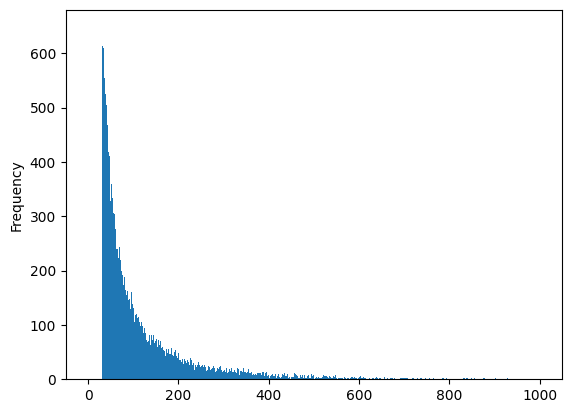

In [11]:
import numpy as np

df["sum_gamerounds"].plot(
    kind="hist",
    bins=np.arange(0, 1000)
)

In [12]:
# 1000번 이상의 플레이를 한 사람들은 총 115명
len(df[df["sum_gamerounds"]>1000])

115

## 2. gate_30 그룹과 gate_40그룹의 플레이 라운드 수의 평균에 대한 t검정
* 두 집단의 sum_gamerounds 값에 대한 등분산 검정을 한 후,
* two sampled t-test를 시행하겠습니다.

### 1단계 - 가설 설정

Ho: gate_30 집단과 gate_40 집단의 플레이 라운드 수의 평균의 차이는 없을 것이다.</br>
H1: gate_30 집단과 gate_40 집단의 플레이 라운드 수의 평균의 차이가 있을 것이다.</br>
유의수준 : .05

$$H_{0}: \mu_{1}-\mu_{2}=0$$
$$H_{a}: \mu_{1}-\mu_{2}\neq0$$

### 2단계 - 등분산 검정(levene)
p-value가 유의수준 .05 보다 높으므로 두 집단은 등분산 가정을 충족합니다.

In [13]:
from scipy import stats

rounds_30 = df[df["version"] == "gate_30"]["sum_gamerounds"]
rounds_40 = df[df["version"] == "gate_40"]["sum_gamerounds"]

stats.levene(rounds_30, rounds_40)

LeveneResult(statistic=0.1049301583062975, pvalue=0.7459936359136907)

### 3단계 - t검정 수행
two sampled t-test 결과, p-value가 유의수준 .05보다 높으므로 영가설을 채택합니다.
즉, gate_30 그룹의 플레이 라운드 평균과 gate_40 그룹의 플레이 라운드 평균의 차이는 통계적으로 유의하지 않습니다.

In [14]:
stats.ttest_ind(
    a=rounds_30, 
    b=rounds_40,
    alternative="two-sided",
    equal_var=True
)

TtestResult(statistic=-1.5205865059389807, pvalue=0.12837313948068096, df=33266.0)

### 4단계 - 결론 기술
유의수준 .05에서 gate_30 그룹의 플레이 라운드 수의 평균과 gate_40 그룹의 플레이 라운드 수의 평균에는 차이가 없습니다.

## 3. version과 retention_1의 독립 여부 (카이 제곱 검정)

### 1단계 - 가설 설정
Ho: version(30/40)과 1일차 retention 여부는 서로 독립관계다.</br>
H1: version(30/40)과 1일차 retention 여부는 서로 독립관계가 아니다(서로 종속관계다).</br>
유의수준 : .05

### 2단계 - 분할표 작성
표만 봐도 둘은 독립관계인 것 같습니다!

In [15]:
retention1_table = pd.crosstab(df["version"], df["retention_1"])
retention1_table

retention_1,False,True
version,,
gate_30,3314,13341
gate_40,3292,13321


### 3단계 - 카이 제곱 검정 시행

In [16]:
from scipy.stats import chi2_contingency

chi2_contingency(retention1_table)

Chi2ContingencyResult(statistic=0.03027400911232281, pvalue=0.8618699583784126, dof=1, expected_freq=array([[ 3307.16995311, 13347.83004689],
       [ 3298.83004689, 13314.16995311]]))

### 4단계 - 결론 기술
p-value가 유의수준 .05보다 크기 때문에 영가설을 채택합니다.
즉, version(30/40)과 1일차 retention 여부는 서로 독립관계다. 

## 4. version과 retention_7의 독립 여부 (카이 제곱 검정)

### 1단계 - 가설 설정
Ho: version(30/40)과 7일차 retention 여부는 서로 독립관계다.</br>
H1: version(30/40)과 7일차 retention 여부는 서로 독립관계가 아니다(서로 종속관계다).</br>
유의수준 : .05

### 2단계 - 분할표 작성
여기도 표만 봐도 둘은 독립관계인 것 같습니다!

In [17]:
retention7_table = pd.crosstab(df["version"], df["retention_7"])
retention7_table

retention_7,False,True
version,,
gate_30,9348,7307
gate_40,9469,7144


### 3단계 - 카이 제곱 검정 시행

In [15]:
chi2_contingency(retention7_table)

Chi2ContingencyResult(statistic=2.528313646462112, pvalue=0.11181966223372168, dof=1, expected_freq=array([[9420.37799086, 7234.62200914],
       [9396.62200914, 7216.37799086]]))

p-value가 유의수준 .05보다 크기 때문에 영가설을 채택합니다. 즉, version(30/40)과 1일차 retention 여부는 서로 독립관입니다.

### 4단계 - 결론 기술
version(30/40)과 1일차 retention 여부는 서로 독립관입니다.

## 5. 플레이라운드가 30이 안 되는 플레이어들은 얼마나 체류했을까?

In [24]:
# 4천명 가까이가 한 번도 플레이하지 않음
df[df["sum_gamerounds"] == 0]

,userid,version,sum_gamerounds,retention_1,retention_7
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
26,3095,gate_30,0,False,False
35,4076,gate_40,0,False,False
37,4176,gate_30,0,False,False
...,...,...,...,...,...
90067,9986185,gate_30,0,False,False
90093,9988600,gate_40,0,False,False
90116,9990773,gate_30,0,False,False
90147,9994604,gate_30,0,False,False


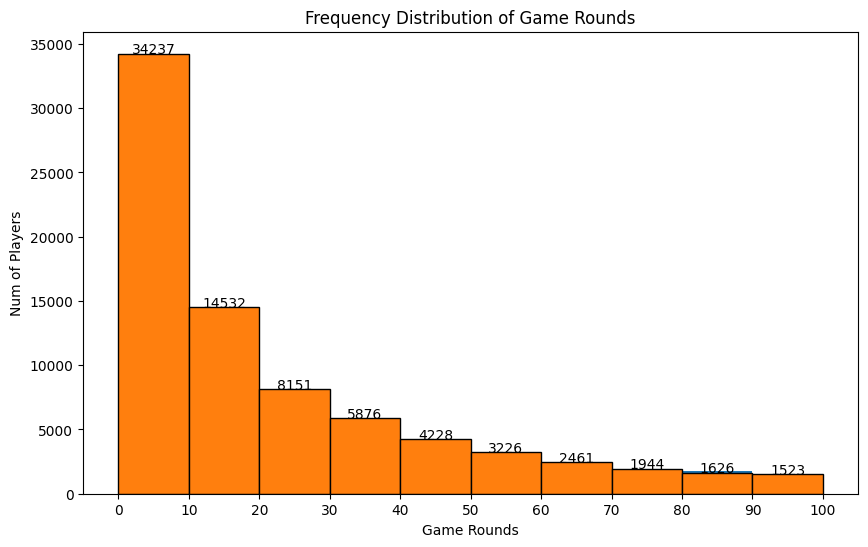

In [46]:
import numpy as np
import matplotlib.pyplot as plt

df["sum_gamerounds"].plot(
    kind="hist",
    bins=np.arange(0, 100, 10)
)

ax = df["sum_gamerounds"].plot(
    kind="hist",
    bins=np.arange(0, 110, 10),
    edgecolor='black',
    figsize=(10, 6)
)

hist, bins = np.histogram(df["sum_gamerounds"], bins=np.arange(0, 110, 10))

for i in range(len(hist)):
    ax.text(bins[i] + 5, hist[i] + 0.5, str(hist[i]), ha='center')

plt.xticks(np.arange(0, 110, 10))
plt.xlabel('Game Rounds')
plt.ylabel('Num of Players')
plt.title('Frequency Distribution of Game Rounds')
plt.xticks(np.arange(0, 110, 10))
plt.show()

##  결론

해당 데이터에서 GATE의 위치는 유저들의 retention에 영향을 미치지 않았으며, 초기이탈율을 줄이는 방안에 더 집중해야 할 것 같다.